In [ ]:
# aggiungere analisi
# weighted recall uguale all'accuracy
# xgb forse può migliorare cambiando il peso delle classi
# TODO: testare tutto, sistemare in ambiente distribuito

# ML algorithm for pattern classification
This notebook contains the definitions and training pipeline of the machine learning algorithms applied in the paper.
For each algorithm, a model will be created with the same hyperparameters as the ones declared in the paper (defaults hyperparameters of <code>sklearn</code>).

Said model will be trained and tested on the split already provided from the beginning of the SeqScout procedure. In this way, we can have a score that is as much as comparable as possible with the values reported by the paper.


Then, an hyperparameter search will be conducted on the models via cross validation on the training split. The best performing model will be again trained on the full train set and tested on test set, in order to compare it to the default model.
Each model will be compared on accuracy, precision and recall. Moreover, the confusion matrix for each best performing model will be produced.

## Major differences
Aside from the machine learning library employed, the presented algorithms differ from the original paper in a couple of aspects:
- They use the OneVsRest classifier for each model, while we use directly the multiclass classifier (except for the LinearSVC). This allows to save time on the model training and consequently on the hyperparameter search.
- The results will be computed on a single test split equal to a fifth of the original dataset. This split follows the same split employed for k-fold evaluation in the original paper. This choice was made considering the high overhead required when computing the patterns.
- As SVM model, pyspark has only the LinearSVC implemented, thus it will be used in place of SVC. In this case, the default parameter considered for the baseline model will be the ones provided by pyspark.

## Imports and library installation
As the default package of PySpark does not include the algorithm for the XGBoost, a cell to install the appropriate libraries is added

In [3]:
!pip install scikit-learn
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 7.0 MB/s eta 0:00:0000:0100:01


In [1]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LinearSVC, OneVsRest, NaiveBayes
from pyspark.ml.classification import DecisionTreeClassificationModel, RandomForestClassificationModel, OneVsRestModel, NaiveBayesModel
from pyspark.mllib.tree import RandomForestModel, DecisionTreeModel
from pyspark.ml.tuning import CrossValidatorModel
from xgboost.spark import SparkXGBClassifier, SparkXGBClassifierModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from utils import load_df
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType, IntegerType
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.stat import Summarizer

## Dataset loading, function definitions and brief preliminary analysis
As first step, we load the already encoded dataframes for training and testing the algorithms. We also set the path where the models will be saved as well as the random seed for reproducibility.

In [2]:
spark = SparkSession.builder.appName("RocketLeagueL").getOrCreate()

#base_path = 'hdfs://hdmaster:9000/user/ubuntu/dataset/'
base_path ='./'
path = base_path + "dataset/"

modelpath = base_path + 'models/'
train = load_df(path, "encoded_df", spark)
test = load_df(path, "encoded_test", spark)
seed = 42


23/10/01 09:29:28 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Cells for the loading of checkpoints of the trained models are then added

In [3]:
# loads base models
print("Loading decision tree...")
dtcf = DecisionTreeClassificationModel.load(modelpath + 'decision_tree/base')
print("Loading random forest...")
rfcf = RandomForestClassificationModel.load(modelpath + 'random_forest/base')
print("Loading XGBoost...")
xgbf = SparkXGBClassifierModel.load(modelpath + 'xgb/base')
print("Loading SVM...")
svmf = OneVsRestModel.load(modelpath + 'svm/base')
print("Loading Naive Bayes...")
nbf = NaiveBayesModel.load(modelpath + 'nb/base')

Loading decision tree...


Loading random forest...


Loading XGBoost...


Loading SVM...
Loading Naive Bayes...


In [4]:
# loads tuned models (takes some time)
print("Loading tuned decision tree...")
dtc_cv_model = CrossValidatorModel.load(modelpath + 'decision_tree/hyperParameterTuned')
print("Loading tuned random forest...")
rfc_cv_model = CrossValidatorModel.load(modelpath + 'random_forest/hyperParameterTuned')
print("Loading tuned XGBoost...")
 
print("Loading tuned SVM...")
svm_cv_model = CrossValidatorModel.load(modelpath + 'svm/hyperParameterTuned')
print("Loading tuned Naive Bayes...")
nb_cv_model = CrossValidatorModel.load(modelpath + 'nb/hyperParameterTuned')

Loading tuned decision tree...
Loading tuned random forest...


Loading tuned XGBoost...
Loading tuned SVM...
Loading tuned Naive Bayes...


Then, a couple of function are defined in order to automatically compute the evaluation metrics and to print them together with the confusion matrix. Moreover, to improve the readability of the produced graph, the list of labels for the classes is also added.

In [3]:
ordered_labels = ['Noise', 
                      'Ceiling Shot', 
                      'Power Shot', 
                      'Waving Dash',
                      'Air Dribbling',
                      'Front Flick',
                      'Musty Flick']

def compute_metrics(prediction_df):
    """
    Function computing some metrics for the evaluation of the machine learning models. It uses MulticlassMetrics from
    the pyspark library.
    params:
        prediction_df: pyspark dataframe containing at least a prediction column called "prediction"
                       amd a class colimn called "class"
    returns:
        a MulticlassMetrics object containing the metrics about the prediction_df
    """
    rdd_pred = prediction_df.select("prediction", "class").withColumn("class",F.col('class').cast(FloatType())).orderBy('class').rdd.map(tuple)
    metrics = MulticlassMetrics(rdd_pred)
    return metrics

def print_metrics(prediction_df, ordered_labels=ordered_labels):
    """
    Function printing some metrics for evaluation, as well as the confusion matrix given a pyspark dataframe
    with ground truth labels and predictions. The confusion matrix is printed with values normalized on the true and false
    positives (precision)
    params:
        prediction_df: pyspark dataframe containing at least a prediction column
                       called "prediction" and a class column called "class"
        ordered_labels: list of labels whose position order corresponds to the position order of the corresponding class values
    """
    metrics = compute_metrics(prediction_df)
    print("Accuracy: ")
    print(f'%.3f'%metrics.accuracy)
    print("Weighted precision: ")
    print(f'%.3f'%metrics.weightedPrecision)
    print("Weighted recall: ")
    print(f'%.3f'%metrics.weightedRecall)
    cm = metrics.confusionMatrix().toArray()
    cm = cm / (cm.sum(axis=0))

    sns.heatmap(cm, annot=True, xticklabels=ordered_labels, yticklabels=ordered_labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    

### Classes distribution
In the following barplots we verify again that the class distribution is equal between the training and the test split, as a stratified one was performed during the pre-processing procedure. The only classes that are slightly skewed in the test set w.r.t. the trianing one are the "Air Dribbling" and "Front Flick" classes.

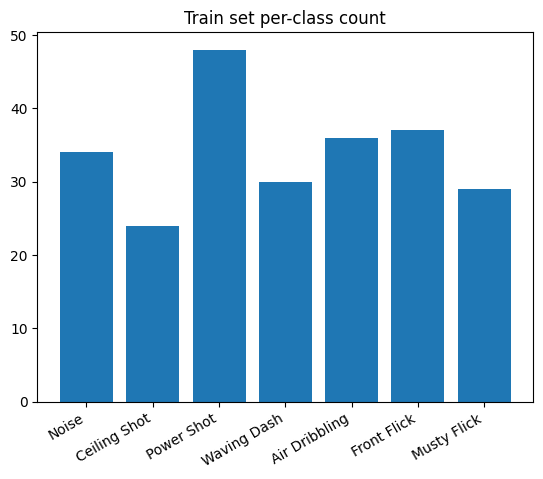

In [87]:
# getting per class counts
hist_data_train = train.groupBy('class').count().sort('class').collect()
# setting label alignment and rotation
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# plotting the values
plt.title("Train set per-class count")
plt.bar(np.arange(len(ordered_labels)),[i['count'] for i in hist_data_train], tick_label=ordered_labels)
plt.show()

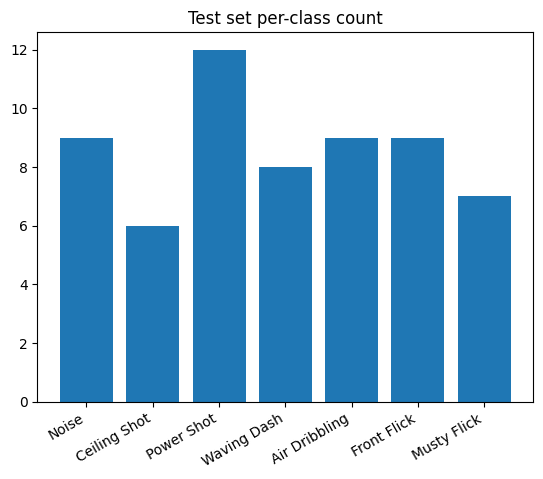

In [86]:
hist_data_test = test.groupBy('class').count().sort('class').collect()
# setting label alignment and rotation
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# plotting the values
plt.title("Test set per-class count")
plt.bar(np.arange(len(ordered_labels)),[i['count'] for i in hist_data_test], tick_label=ordered_labels)
plt.show()

### Features distribution
Then, since at this point the dataset is mainly constituted of binary features indicating whether a specific pattern has been found in a sequence, we can see how these pattern effectively encode the charateristics of a class. 

In order to do so, we group the DataFrame by class, sum over the values of the binary features, normalize this values by column and then show the results as a heatmap. 

We should expect the heatmap to show the "main diagonal" to have higher values (shown with brighter colors) and since the features were added by following the order induced by the values used to indicate the classes (e.g. first 20 features/patterns refers to the "Ceiling Shot" (class 1), the following 20 refers to "Power Shot" (class 2), etc.)

In [78]:
def show_heatmap(dataframe, c="class", feats="features", ordered_labels=ordered_labels):
    """
    Function printing the heatmap of a given binary dataframe. In particular, the function groups the rows by the column
    c, sums the values in feats and then turns them into percentage.
    params:
        dataframe: input dataframe containing the information to be aggregated
        c: column name to be used to group the records
        feats: name of the column to be aggregated
        ordered_labels: list of ordered names to be given to the rows of the heatmap
    """
    summarized_df = dataframe.groupBy(c).agg(Summarizer.sum(F.col(feats)).alias("per_c_sum")).orderBy(c)\
                    .select("per_c_sum")
    norm = summarized_df.agg(Summarizer.sum(summarized_df.per_c_sum).alias("norm")).collect()[0].asDict()["norm"] 
    if norm.numNonzeros() != len(norm):
        norm = norm.toArray()
        norm[norm == 0.] = 1
    summarized_df = summarized_df.collect()
    summarized_df = [summarized_df[i].asDict()["per_c_sum"]/norm for i in range(len(summarized_df))]
    fig, ax = plt.subplots(figsize=(25,3)) 
    sns.heatmap(summarized_df, yticklabels=ordered_labels, ax=ax)
    plt.xlabel("features")
    plt.show()

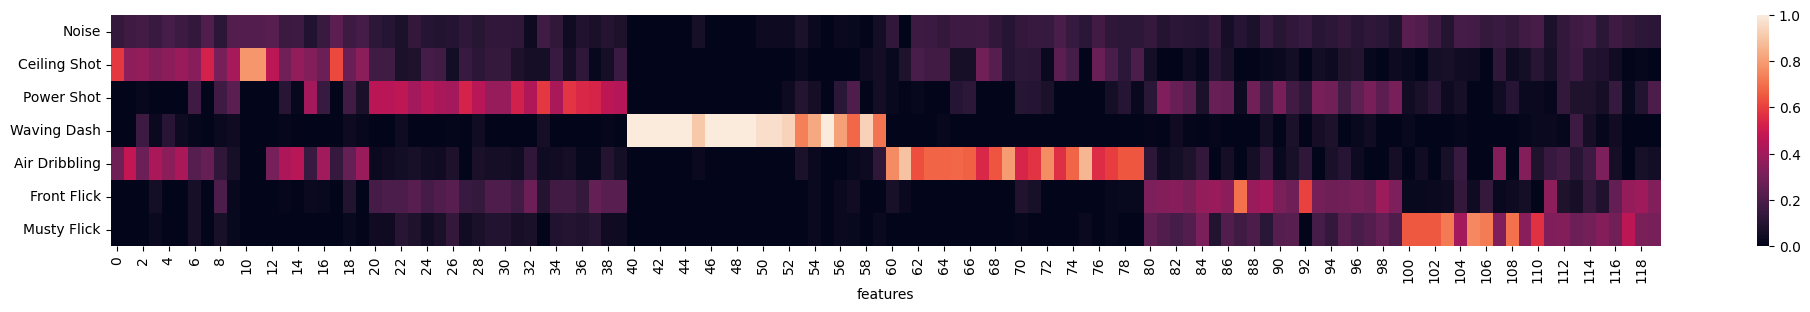

In [79]:
show_heatmap(train)

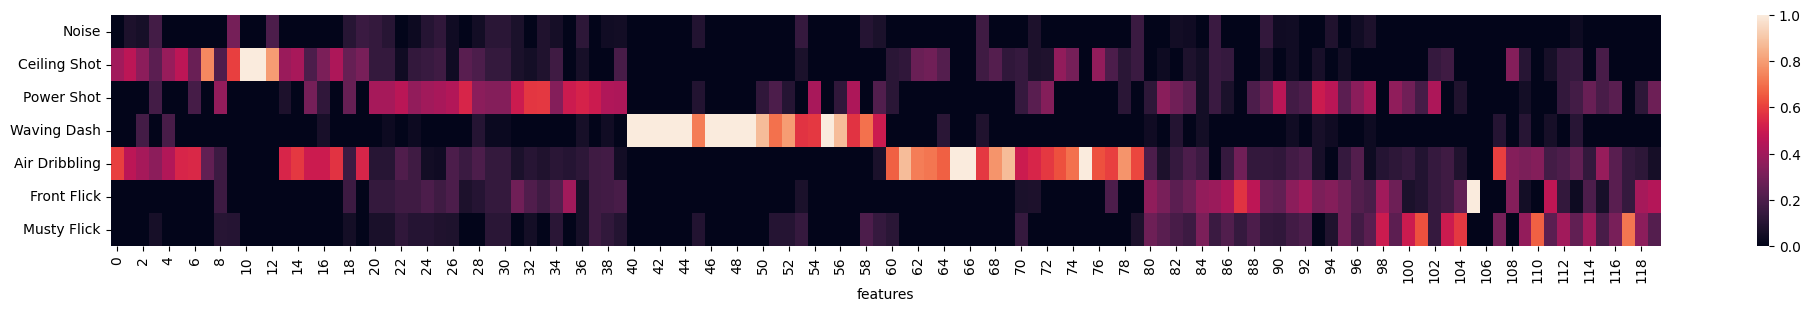

In [80]:
show_heatmap(test)

The general trend follows what we were expecting, having brighter colors on the main diagonal. Said diagonal is "sharper" on the training set w.r.t to the test split as the patterns were extracted directly from that part of the dataset. 

We can also observe that the first row, referring to the noise sequences, incorporates most of the patterns but never in a distinctive way.

Finally we can also observe that some patterns can consistently encode also shots for which do not belong to the same class for which they were extracted for:
- Patterns for "Ceiling shot" found in "Air Dribbling" (and viceversa);
- Patterns for "Power shot" found in "Front Flick" (and viceversa);
- Patterns for "Front flick" found in "Musty Flick" (and viceversa, even if less prominent).

This can be explained considering that said pairs of shots have similar setups and/or are similar in nature. With the same background knowledge on the game, we can explain why the patterns for the "Waving Dash" pattern are more clearly defined. In fact, differently from the other tricks, its the only one that is purely used for movement rather than scoring a point.

In conclusion, even if the analysis is somewhat reductive as it doesn't take into account the correlations between the patterns, it will be still useful to help analyzing the results of the models.

# Machine Learning models training and tuning
As previously said, we start by creating a base model which will also serve as comparison.
Then we proceed to apply a grid search with a 4-fold cross validation to find the best set of hyperparameters for the models.
The models are automatically re-trained on the full training at the end of the CV procedure.

## Decision Tree

To reproduce the results obtained with default Scikit Learn parameters, we set the <code>max_depth</code> parameter to 30 which is the maximum supported by PySpark and should act as "unconstrained" depth.

In [8]:
dtc = DecisionTreeClassifier(maxDepth=30, seed=seed, featuresCol='features', labelCol='class')
# apparently 30 is the currently supported maximum depth for pyspark

# fitting the model
dtcf = dtc.fit(train)
# saving
dtcf.save(modelpath + 'decision_tree/base')

+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       0.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    6|
|       6.0|    6|
|       1.0|    1|
|       0.0|    1|
|       0.0|    1|
+----------+-----+
only showing top 15 rows

Accuracy: 
0.733
Weighted precision: 
0.823
Weighted recall: 
0.733


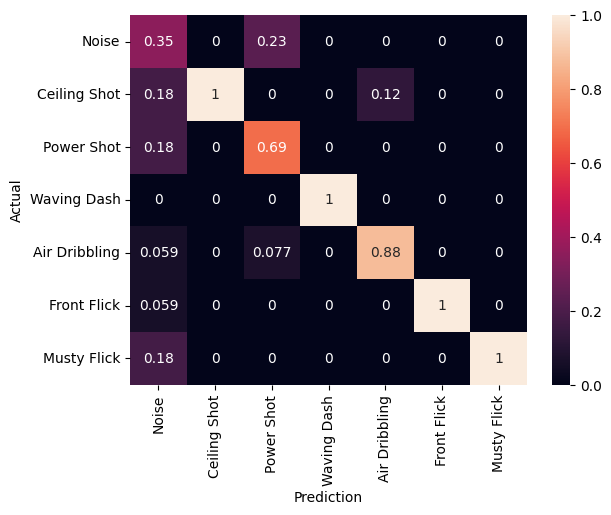

In [9]:
# getting predictions
dtc_predictions = dtcf.transform(test)
dtc_predictions.select("prediction", "class").show(15)
print_metrics(dtc_predictions)

In the case of the Decision tree we optimize w.r.t the following hyperparameters:
- Impurity criterion: Gini index or entropy;
- Maximum depth of the tree: between 3 and 15. Since the features are binary, 3 is chosen as it allows to create a tree with at least 8 different labeled leaf nodes, which is slightly above the number of classes (7);
- Minimum instances in a leaf node: between 1 to 5;
- Minimum gain in the impurity criterion to apply the split: in [0.1, 1] with steps of 0.1.

In [65]:
# base model
dtc_cv = DecisionTreeClassifier(featuresCol='features', labelCol='class',seed=seed)
# creating the grid
dtc_param_grid = ParamGridBuilder()\
                .addGrid(dtc_cv.impurity, ['gini', 'entropy'])\
                .addGrid(dtc_cv.maxDepth, [i+1 for i in range(3,15)])\
                .addGrid(dtc_cv.minInstancesPerNode, [i+1 for i in range(5)])\
                .addGrid(dtc_cv.minInfoGain, [0.1*i for i in range(11)]).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

dtc_cross_val = CrossValidator(estimator=dtc_cv,
                              estimatorParamMaps=dtc_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [7]:
# fitting and tuning
dtc_cv_model = dtc_cross_val.fit(train)

Here we save the model and plot the best hyperparameters found...

In [45]:
print("Best parameters:")
print({k.name : v for (k,v) in dtc_cv_model.getEstimatorParamMaps()[np.argmax(dtc_cv_model.avgMetrics)].items()})
dtc_cv_model.save(model_path+"decision_tree/hyperParameterTuned")

Best parameters:
{'minInfoGain': 0.2, 'minInstancesPerNode': 2, 'impurity': 'entropy', 'maxDepth': 7}


...And the results.

+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       0.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    6|
|       6.0|    6|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
+----------+-----+
only showing top 15 rows

Accuracy: 
0.800
Weighted precision: 
0.846
Weighted recall: 
0.800


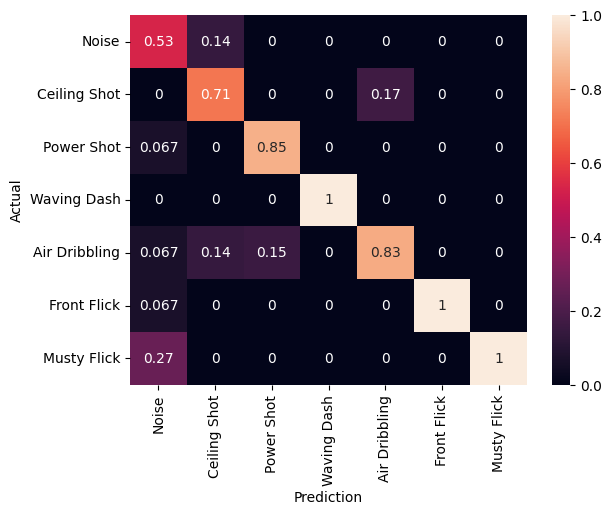

In [10]:
dtc_best_pred = dtc_cv_model.transform(test)
dtc_best_pred.select("prediction", 'class').show(15)
print_metrics(dtc_best_pred)

The tuned model has increased general performances w.r.t the base one, recording a ~+0.7% on accuracy and recall and a ~+0.23% on precision.

Looking at the confusion matrixes, we can observe that:
- Both models perfectly classify the "Waving Dash" class as expected from the observation of the features distribution. In fact, its the only class with more "unique" patterns w.r.t. the others extracted;
- The tuned model can more precisely classify the "noise" and "Power Shot" classes which probably is the main reason why the aggregated performances are higher if compared with the base model. On the other side, it tends to classify "Musty flick" more as "Noise" more frequently;
- In the tuned model there is more confusion between "Air Dribbling" and "Ceiling shot" and "Power shot" when compared with the the base model. This confusion can still be explained by the representations ("Air Dribbling" is encoded more frequently with patterns of "Power shot" in the test set) and the observations made from the feature distribution. 

## Random Forest

In [ ]:
rfc = RandomForestClassifier(featuresCol='features',
                             labelCol='class',
                             featureSubsetStrategy='sqrt',
                             maxDepth=30,
                             numTrees=100,
                             seed=seed)
#fitting the model
rfcf = rfc.fit(train)
# saving
rfcf.save(model_path+"models/random_forest/base")

23/09/30 17:23:16 WARN DAGScheduler: Broadcasting large task binary with size 1381.0 KiB
+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    6|       6.0|
|    6|       6.0|
|    1|       1.0|
|    1|       0.0|
|    1|       0.0|
+-----+----------+
only showing top 15 rows

23/09/30 17:23:16 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
23/09/30 17:23:16 WARN DAGScheduler: Broadcasting large task binary with size 1384.6 KiB
23/09/30 17:23:16 WARN DAGScheduler: Broadcasting large task binary with size 1392.9 KiB
Accuracy: 
23/09/30 17:23:16 WARN DAGScheduler: Broadcasting large task binary with size 1403.3 KiB
0.850
Weighted precision: 
0.874
Weighted recall: 
0.850


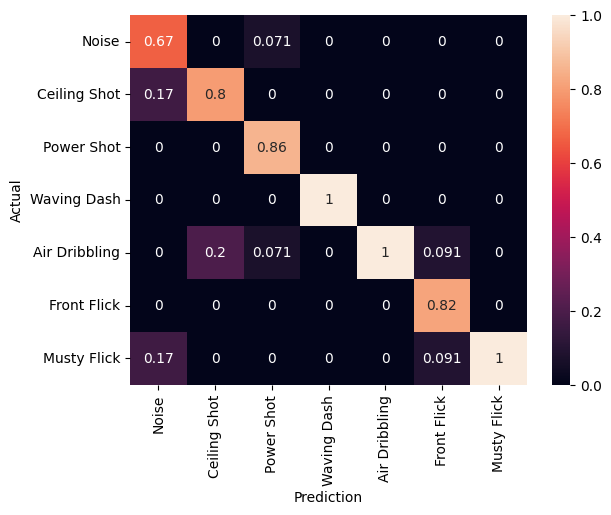

In [22]:
# getting predictions
rfc_predictions = rfcf.transform(test)
rfc_predictions.select('class', 'prediction').show(15)
print_metrics(rfc_predictions)

For the Random forest we build the grid on the following parameters:
- Impurity measure: Gini index or entropy;
- Maximum depth of the trees: between 3 and 10. The range is reduced w.r.t. the decision tree after checking that the best <code>max_depth</code> for the tree is 7;
- Minimum instances in a leaf node: between 1 and 3. Also here the range is reduced as above;
- Minimum information gain for the split: in {0.2, 0.4, 0.6, 0.8, 1};
- Strategy for the selection of features when building a new tree: between all the available ones - all, one third of the total, square root of the total, base 2 logarithm of the total;
- Number of trees in the forest: in {25, 50, 75, 100, 125, 150, 175, 200};
- Subsampling percentage to be applied on the dataset when building a tree: in {0.2, 0.4, 0.6, 0.8, 1}

In [12]:
# base model
rfc_cv = RandomForestClassifier(featuresCol='features', labelCol='class',seed=seed)

# in hyperparameters optimization we are considering only the automatic feature selection methods
rfc_param_grid = ParamGridBuilder()\
                .addGrid(rfc_cv.impurity, ['gini', 'entropy'])\
                .addGrid(rfc_cv.maxDepth, [i+1 for i in range(3,10)])\
                .addGrid(rfc_cv.minInstancesPerNode, [i+1 for i in range(3)])\
                .addGrid(rfc_cv.minInfoGain, [0.2*i for i in range(1,6)])\
                .addGrid(rfc_cv.featureSubsetStrategy, ['sqrt', 'all', 'log2', 'onethird'])\
                .addGrid(rfc_cv.numTrees, [25*i for i in range(1,9)])\
                .addGrid(rfc_cv.subsamplingRate, [0.2*i for i in range(1, 6)]).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')


rfc_cross_val = CrossValidator(estimator=rfc_cv,
                              estimatorParamMaps=rfc_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [ ]:
# fitting and tuning
rfc_cv_model = rfc_cross_val.fit(train)

Here we save the model and plot the best hyperparameters found...

In [46]:
print("Best parameters:")
print({k.name : v for (k,v) in rfc_cv_model.getEstimatorParamMaps()[np.argmax(rfc_cv_model.avgMetrics)].items()})
rfc_cv_model.save(model_path+"random_forest/hyperParameterTuned")

Best parameters:
{'featureSubsetStrategy': 'onethird', 'numTrees': 25, 'maxDepth': 7, 'impurity': 'entropy', 'minInfoGain': 0.2, 'minInstancesPerNode': 1, 'subsamplingRate': 0.8}


...And the results.

+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    6|
|       6.0|    6|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
+----------+-----+
only showing top 15 rows

Accuracy: 
0.883
Weighted precision: 
0.897
Weighted recall: 
0.883


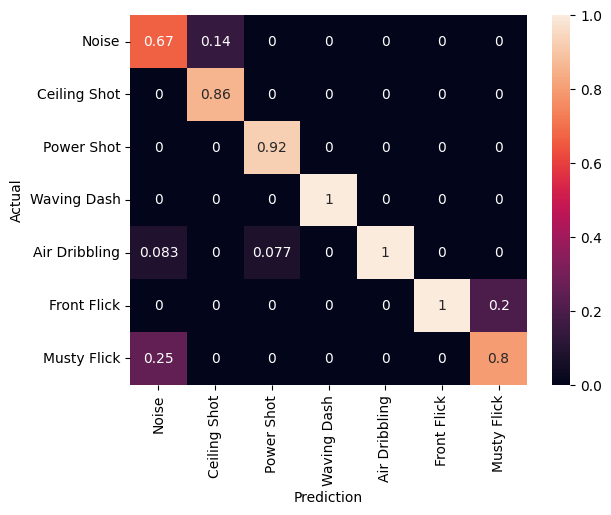

In [23]:
rfc_best_pred = rfc_cv_model.transform(test)
rfc_best_pred.select("prediction", 'class').show(15)
print_metrics(rfc_best_pred)

Again, the tuned model shows improvements on all the metrics w.r.t. the base one, which already represented a good starting point. The tuned model records an increase of ~+0.33% in accuracy and recall and of ~+0.26% in precision. The Random Tree can overcome the similarity between classes (e.g. "Air Dribbling" - "Ceiling shot") better than the other models as it can more easily consider the different correlations between features thanks to the usage of the ensamble technique.

In particular, we can see:
- Higher precision on "Ceiling Shot", "Power Shot" and "Front Flick";
- There's still some error in classfying some classes as "noise";
- There's less precision on "Musty Flick", as it is confused with the similar class "Front Flick";
- There is still some slight confusion on "Power shot" and "Air Dribbling" due to the way the patterns encoded the test set.


## XGBoost

In [17]:
xgb = SparkXGBClassifier(features_col='features',
                         label_col='class',
                         random_state=seed)
# fitting the model
xgbf = xgb.fit(train)
# saving the model
xgbf.save(model_path+'xgb/base')

2023-09-17 20:56:02,491 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'max_depth': 7, 'random_state': 42, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[20:56:03] task 0 got new rank 0                                    (0 + 1) / 1]
2023-09-17 20:56:04,981 INFO XGBoost-PySpark: _fit Finished xgboost training!   


2023-09-30 19:21:03,245 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       0.0|
|    6|       6.0|
|    6|       6.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
+-----+----------+
only showing top 15 rows



2023-09-30 19:21:04,109 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-09-30 19:21:04,217 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy: 
0.833
Weighted precision: 
0.899
Weighted recall: 
0.833


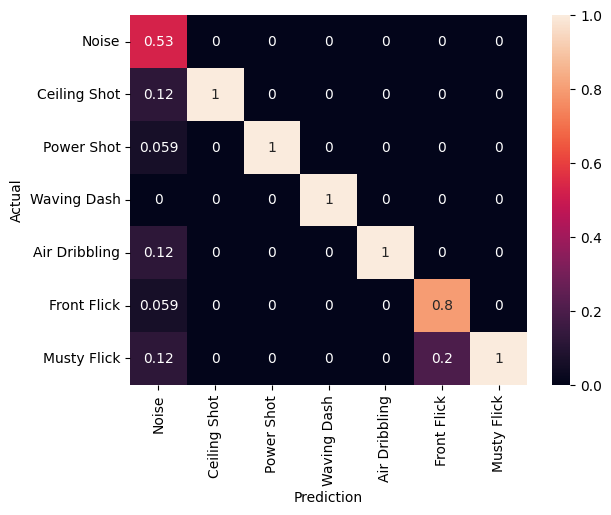

In [101]:
# getting the results
xgb_predictions = xgbf.transform(test)
xgb_predictions.select('class', 'prediction').show(15)
print_metrics(xgb_predictions)

Due to the large hyperparameter space of XGBoost, the search was intially focused on the more important parameters to be tuned.
The values were chosen based on previous results on the Decision Tree (<code>max_depth</code>) or considering this [article](https://machinelearningmastery.com/configure-gradient-boosting-algorithm/) as a reference. Also the set of hyperparameters is restricted due to the overhead required for training.
The tuned parameters are:
- Learning rate: in {0.01, 0.1, 0.3};
- Maximum depth of the tree: in {5, 6, 7, 8, 9};
- Lambda regularization term (L2): in {0, 0.1, 0.5, 1};
- Alpha regularization term (L1): in {0, 0.1, 0.5, 1};
- Feature sample rate to be applied at each boosting round: in {0.5, 0.75, 1};
- Number of boosting rounds: in {50, 100, 200}.

Other parameters were also tested (as <code>colsample_bynode</code>, <code>colsample_by_level</code>, <code>subsample</code>, DART booster...) but they are not presented as they didn't improve the performances of the model.

In [24]:
# base model
xgb_cv = SparkXGBClassifier(features_col='features',
                         label_col='class',
                         verbose=0,
                         random_state=seed)
# building the grid
xgb_param_grid = ParamGridBuilder()\
                .baseOn({xgb_cv.verbose:0})\
                .addGrid(xgb_cv.learning_rate, [0.01, 0.1, 0.3])\
                .addGrid(xgb_cv.max_depth, [i for i in range(5,9)])\
                .addGrid(xgb_cv.reg_lambda, [0, 0.1, 0.5, 1])\
                .addGrid(xgb_cv.reg_alpha, [0, 0.1, 0.5, 1])\
                .addGrid(xgb_cv.colsample_bytree, [0.5, 0.75, 1])\
                .addGrid(xgb_cv.n_estimators, [50, 100, 200]).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

xgb_cross_val = CrossValidator(estimator=xgb_cv,
                              estimatorParamMaps=xgb_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [ ]:
xgb_cv_model = xgb_cross_val.fit(train)

Here we save the model and plot the best hyperparameters found...

In [58]:
print("Best parameters:")
print({k.name : v for (k,v) in xgb_cv_model.getEstimatorParamMaps()[np.argmax(xgb_cv_model.avgMetrics)].items()})
xgb_cv_model.save(model_path+"xgb/hyperParameterTuned")

Best parameters:
{'verbose': 0, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'colsample_bytree': 1, 'n_estimators': 100}


...And the results.

In [97]:
j=0
print((len(xgb_cv_model.avgMetrics)))
for k in [0, 0.1, 0.5, 1]:
    local_max = 0
    for i in range(len(xgb_cv_model.avgMetrics)):
        if {k.name : v for (k,v) in xgb_cv_model.getEstimatorParamMaps()[i].items()}['reg_alpha']==k:
            if xgb_cv_model.avgMetrics[i] > xgb_cv_model.avgMetrics[local_max]:
                local_max = i
            #print("-------------")
            #print({k.name : v for (k,v) in xgb_cv_model.getEstimatorParamMaps()[i].items()})
            #print(xgb_cv_model.avgMetrics[i])
    print(f'------ {k}')
    print({k.name : v for (k,v) in xgb_cv_model.getEstimatorParamMaps()[local_max].items()})
    print(xgb_cv_model.avgMetrics[local_max])

1728
------ 0
{'verbose': 0, 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'colsample_bytree': 1, 'n_estimators': 200}
0.8758411438098939
------ 0.1
{'verbose': 0, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'colsample_bytree': 1, 'n_estimators': 100}
0.8758411438098939
------ 0.5
{'verbose': 0, 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 0, 'reg_alpha': 0.5, 'colsample_bytree': 1, 'n_estimators': 100}
0.8674495354182854
------ 1
{'verbose': 0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 1, 'reg_alpha': 1, 'colsample_bytree': 1, 'n_estimators': 100}
0.859057927026677


2023-09-27 23:58:58,727 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       0.0|    5|
|       6.0|    6|
|       6.0|    6|
|       1.0|    1|
|       1.0|    1|
|       0.0|    1|
+----------+-----+
only showing top 15 rows



2023-09-27 23:58:59,567 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-09-27 23:58:59,681 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy: 
0.833
Weighted precision: 
0.893
Weighted recall: 
0.833


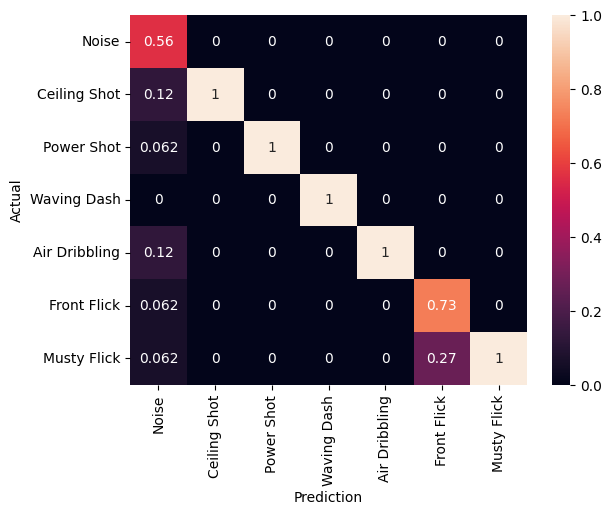

In [53]:
#getting the results
xgb_best_pred = xgb_cv_model.transform(test)
xgb_best_pred.select("prediction", 'class').show(15)
print_metrics(xgb_best_pred)

As we can see we, we achieved almost identical performances as the default model. Thus another round of optimization was attempted (other than testing the other parameters previously listed).
This time, the parameters explored were:
- Lambda regularization term (L2): in {0, 0.1, 0.5};
- Alpha regularization term (L1): in {0, 0.1, 0.3};
- Gamma (Minimum loss delta): in {0.01,0.025, 0.05};
- Minimum sum of weights to proceed with splitting: between 1 and 1.1

Other parameters were fixed instead, by looking which values in the previous tuning round more likely would bring good results:
- <code>max_depth</code> = 8;
- <code>learning_rate</code> = 0.1;
- <code>num_estimators</code> = 200;

Other than these values, other combinations were tested, as also trying to use less boosting rounds, but also here they did not improve the model.

In [39]:
# base model
xgb_cv2 = SparkXGBClassifier(features_col='features',
                         label_col='class',
                         verbose=0,
                         random_state=seed)
# building the grid
xgb_param_grid2 = ParamGridBuilder()\
                .baseOn({xgb_cv2.n_estimators:200, xgb_cv2.learning_rate:0.1, xgb_cv2.max_depth: 8})\
                .addGrid(xgb_cv2.reg_lambda, [0, 0.1, 0.5 ])\
                .addGrid(xgb_cv2.reg_alpha, [0, 0.1, 0.3])\
                .addGrid(xgb_cv2.gamma, [0.01, 0.025, 0.05])\
                .addGrid(xgb_cv2.min_child_weight, [1, 1.1]).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

xgb_cross_val2 = CrossValidator(estimator=xgb_cv2,
                              estimatorParamMaps=xgb_param_grid2,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [ ]:
xgb_cv_model2 = xgb_cross_val2.fit(train)

Here we save the model and plot the best hyperparameters found...

In [53]:
print("Best parameters:")
print({k.name : v for (k,v) in xgb_cv_model2.getEstimatorParamMaps()[np.argmax(xgb_cv_model2.avgMetrics)].items()})

Best parameters:
{'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'gamma': 0.05, 'min_child_weight': 1, 'subsample': 1, 'colsample_bytree': 1}


In [9]:
xgb_cv_model2.save(path+"models/xgb/hyperParameterTuned2")

23/09/19 21:56:33 WARN TaskSetManager: Stage 80362 contains a task of very large size (1643 KiB). The maximum recommended task size is 1000 KiB.


...And the results.

2023-09-30 18:24:10,266 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       0.0|    5|
|       6.0|    6|
|       6.0|    6|
|       1.0|    1|
|       1.0|    1|
|       0.0|    1|
+----------+-----+
only showing top 15 rows



2023-09-30 18:24:11,097 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-09-30 18:24:11,215 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy: 
0.833
Weighted precision: 
0.899
Weighted recall: 
0.833


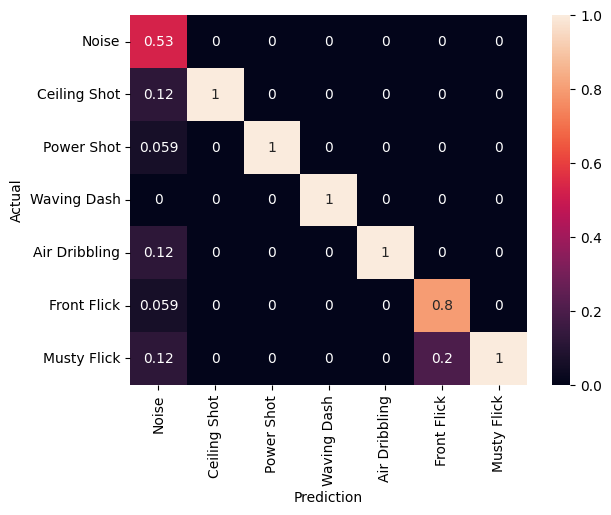

In [40]:
xgb_best_pred2 = xgb_cv_model2.transform(test)
xgb_best_pred2.select("prediction", 'class').show(15)
print_metrics(xgb_best_pred2)

# --------------------------------------------------------------------------------------------------------

In [8]:
# base model
xgb_cv2 = SparkXGBClassifier(features_col='features',
                         label_col='class',
#                         weight_col='weights',
                         verbose=0,
                         random_state=seed)
# building the grid
"""xgb_param_grid2 = ParamGridBuilder()\
                .baseOn({xgb_cv2.learning_rate:0.1, xgb_cv2.max_depth: 7})\
                .addGrid(xgb_cv2.subsample, [0.5, 0.75])\
                .addGrid(xgb_cv2.colsample_bytree, [0.5, 0.75])\
                .addGrid(xgb_cv2.n_estimators, [10, 15, 20, 25])\
                .addGrid(xgb_cv2.reg_lambda, [2, 1.5, 1])\
                .addGrid(xgb_cv2.reg_alpha, [2, 1.5, 1])\
                .addGrid(xgb_cv2.gamma, [2, 1, 0.5, 0.1]).build()"""
xgb_param_grid2 = ParamGridBuilder()\
                .baseOn({xgb_cv2.learning_rate:0.1, xgb_cv2.max_depth: 7})\
                .addGrid(xgb_cv2.subsample, [0.5, 0.75])\
                .addGrid(xgb_cv2.colsample_bytree, [0.5, 0.75])\
                .addGrid(xgb_cv2.n_estimators, [10, 15, 20, 25])\
                .addGrid(xgb_cv2.reg_lambda, [1.5, 1, 0.75])\
                .addGrid(xgb_cv2.reg_alpha, [1.5, 1, 0.75])\
                .addGrid(xgb_cv2.gamma, [1, 0.5, 0.25]).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

xgb_cross_val2 = CrossValidator(estimator=xgb_cv2,
                              estimatorParamMaps=xgb_param_grid2,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)

2023-10-01 16:34:52,324 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:34:52,327 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:34:54] task 0 got new rank 0 1) / 1][Stage 92198:>              (0 + 1) / 1]
[16:34:

[16:35:11] task 0 got new rank 0 1) / 1][Stage 92294:>              (0 + 1) / 1]
[16:35:11] task 0 got new rank 0
2023-10-01 16:35:12,271 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:35:12,280 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:35:12,582 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:35:12,600 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_

2023-10-01 16:35:28,475 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:35:29] task 0 got new rank 0 1) / 1][Stage 92406:>              (0 + 1) / 1]
[16:35:29] task 0 got new rank 0
2023-10-01 16:35:30,794 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:35:30,887 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:35:31,065 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learni

[16:35:45] task 0 got new rank 0 1) / 1][Stage 92502:>              (0 + 1) / 1]
[16:35:46] task 0 got new rank 0
2023-10-01 16:35:46,992 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:35:47,103 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:35:47,214 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:35:47,347 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learnin

2023-10-01 16:36:02,993 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:36:04] task 0 got new rank 0 1) / 1][Stage 92614:>              (0 + 1) / 1]
[16:36:04] task 0 got new rank 0
2023-10-01 16:36:05,294 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:36:05,306 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:36:05,573 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'lea

[16:36:19] task 0 got new rank 0 1) / 1][Stage 92710:>              (0 + 1) / 1]
[16:36:19] task 0 got new rank 0
2023-10-01 16:36:21,047 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:36:21,076 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:36:21,290 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:36:21,309 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_r

2023-10-01 16:36:37,125 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:36:37] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:36:37,379 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:36:38,359 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:36:38,560 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_sta

2023-10-01 16:36:54,191 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:36:55,137 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:36:55,346 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_k

2023-10-01 16:37:12,501 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:37:12] task 0 got new rank 0
2023-10-01 16:37:12,720 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:37:13,743 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:37:13] task 0 got new rank 0
2023-10-01 16:37:13,948 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objectiv

[16:37:29] task 0 got new rank 0
2023-10-01 16:37:30,279 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:37:30] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:37:30,500 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:37:31,686 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:37:31] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:37:31,897 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1,

2023-10-01 16:37:46,889 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:37:47] task 0 got new rank 0
2023-10-01 16:37:47,100 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:37:48,178 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:37:48] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:37:48,392 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'object

2023-10-01 16:38:03,444 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:38:04,667 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:38:04] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:38:04,889 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0

2023-10-01 16:38:21,613 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:38:21] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:38:21,818 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:38:22,820 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:38:23] task 0 got new rank 0
2023-10-01 16:38:23,052 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'object

2023-10-01 16:38:39,434 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:38:39] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:38:39,678 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:38:40,651 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:38:40,873 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42

2023-10-01 16:38:56,348 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:38:56] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:38:56,572 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:38:57,504 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:38:57,714 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_s

2023-10-01 16:39:13,212 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:39:13] task 0 got new rank 0
2023-10-01 16:39:14,368 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:39:14] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:39:14,590 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_

2023-10-01 16:39:31,034 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:39:31] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:39:31,264 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:39:32,258 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:39:32] task 0 got new rank 0
2023-10-01 16:39:32,468 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'object

2023-10-01 16:39:47,828 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:39:48,888 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:39:49] task 0 got new rank 0
2023-10-01 16:39:49,094 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0

2023-10-01 16:40:05,384 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:40:05] task 0 got new rank 0
2023-10-01 16:40:05,585 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:40:06,616 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:40:06] task 0 got new rank 0
2023-10-01 16:40:06,817 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objecti

2023-10-01 16:40:22,622 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:40:23,667 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:40:23] task 0 got new rank 0
2023-10-01 16:40:23,878 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0

2023-10-01 16:40:40,214 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:40:40] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:40:40,441 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:40:41,410 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:40:41,611 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_st

2023-10-01 16:40:57,923 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:40:58] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:40:58,148 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:40:59,126 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:40:59] task 0 got new rank 0
2023-10-01 16:40:59,332 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'mul

2023-10-01 16:41:14,888 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:41:15,893 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:41:16] task 0 got new rank 0
2023-10-01 16:41:16,096 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verb

2023-10-01 16:41:32,313 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:41:32] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:41:32,524 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:41:33,534 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:41:33] task 0 got new rank 0
2023-10-01 16:41:33,737 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'mul

2023-10-01 16:41:50,051 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:41:50] task 0 got new rank 0
2023-10-01 16:41:50,258 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:41:51,352 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:41:51] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:41:51,569 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objectiv

2023-10-01 16:42:06,519 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:42:06,720 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:42:07] task 0 got new rank 0
[16:42:08] task 0 got new rank 0 1) / 1][Stage 94878:>              (0 + 1) / 1]
2023-10-01 16:42:08,296 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:42:08,493 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'lear

[16:42:22] task 0 got new rank 0
2023-10-01 16:42:23,363 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:42:23] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:42:23,584 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:42:24,476 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:42:24,681 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objec

2023-10-01 16:42:39,903 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:42:39] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:42:40,175 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:42:41,232 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:42:41] task 0 got new rank 0
2023-10-01 16:42:41,441 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective':

2023-10-01 16:42:57,200 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:42:58,298 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:42:58] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:42:58,528 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbo

INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:43:14,069 INFO XGBoost-PySpark: _fit Finished xgboost training!
2023-10-01 16:43:14,153 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:43:14,309 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params

2023-10-01 16:43:30,347 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:43:31] task 0 got new rank 0 1) / 1][Stage 95398:>              (0 + 1) / 1]
[16:43:31] task 0 got new rank 0
2023-10-01 16:43:32,642 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:43:32,665 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:43:32,894 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'lea

[16:43:47] task 0 got new rank 0 1) / 1][Stage 95494:>              (0 + 1) / 1]
[16:43:47] task 0 got new rank 0
2023-10-01 16:43:48,488 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:43:48,527 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:43:48,737 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:43:48,766 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learn

2023-10-01 16:44:04,589 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:44:05] task 0 got new rank 0 1) / 1][Stage 95606:>              (0 + 1) / 1]
[16:44:05] task 0 got new rank 0
2023-10-01 16:44:06,940 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:44:06,947 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:44:07,193 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'lear

[16:44:21] task 0 got new rank 0 1) / 1][Stage 95702:>              (0 + 1) / 1]
[16:44:21] task 0 got new rank 0
2023-10-01 16:44:22,720 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:44:22,860 INFO XGBoost-PySpark: _fit Finished xgboost training!
2023-10-01 16:44:22,938 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:44:23,085 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'lear

INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:44:38,594 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:44:39] task 0 got new rank 0 1) / 1][Stage 95814:>              (0 + 1) / 1]
[16:44:39] task 0 got new rank 0
2023-10-01 16:44:40,749 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:44:40,883 INFO XGBoost-PySpark: _fit Finished xgboost training!
2023-10-01 16:44:40,958 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learnin

[16:44:55] task 0 got new rank 0 1) / 1][Stage 95910:>              (0 + 1) / 1]
[16:44:55] task 0 got new rank 0
2023-10-01 16:44:56,361 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:44:56,445 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:44:56,602 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:44:56,708 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'le

2023-10-01 16:45:12,149 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:45:13] task 0 got new rank 0 1) / 1][Stage 96022:>              (0 + 1) / 1]
[16:45:13] task 0 got new rank 0
2023-10-01 16:45:14,448 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:45:14,488 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:45:14,685 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'lear

[16:45:29] task 0 got new rank 0
[16:45:30] task 0 got new rank 0 1) / 1][Stage 96126:>              (0 + 1) / 1]
2023-10-01 16:45:30,594 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:45:30,798 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:45:31,689 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:45:31,891 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 

2023-10-01 16:45:47,431 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:45:47,636 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:45:47] task 0 got new rank 0
2023-10-01 16:45:48,788 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:45:48] task 0 got new rank 0
2023-10-01 16:45:48,997 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective':

2023-10-01 16:46:04,295 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:46:05,366 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:46:05] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:46:05,585 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eva

2023-10-01 16:46:22,401 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:46:22] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:46:22,618 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:46:23,613 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:46:23] task 0 got new rank 0
2023-10-01 16:46:23,817 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective':

2023-10-01 16:46:40,524 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:46:40] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:46:40,736 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:46:41,622 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:46:41,824 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_st

INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:46:57,489 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:46:58,452 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:46:58,665 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_par

[16:47:14] task 0 got new rank 0
2023-10-01 16:47:15,295 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:47:15] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:47:15,516 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:47:16,494 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:47:16,694 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objecti

2023-10-01 16:47:31,896 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:47:32,897 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:47:33] task 0 got new rank 0
2023-10-01 16:47:33,097 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_ev

2023-10-01 16:47:49,705 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:47:49] task 0 got new rank 0
2023-10-01 16:47:49,914 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:47:51,013 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:47:51] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:47:51,244 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objecti

2023-10-01 16:48:06,365 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:48:07,429 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:48:07] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:48:07,645 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_ev

2023-10-01 16:48:24,248 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:48:24] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:48:24,468 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:48:25,450 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:48:25,653 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_st

2023-10-01 16:48:40,928 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:48:41] task 0 got new rank 0
2023-10-01 16:48:41,143 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:48:42,238 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:48:42] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:48:42,452 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective

2023-10-01 16:48:57,558 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:48:58,581 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:48:58] task 0 got new rank 0
2023-10-01 16:48:58,780 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_e

2023-10-01 16:49:15,249 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:49:15] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:49:15,476 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:49:16,510 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:49:16] task 0 got new rank 0
2023-10-01 16:49:16,713 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective'

2023-10-01 16:49:32,247 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:49:33,254 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:49:33] task 0 got new rank 0
2023-10-01 16:49:33,457 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_e

2023-10-01 16:49:50,569 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:49:50] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:49:50,779 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:49:51,674 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:49:51,886 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state

2023-10-01 16:50:08,321 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:50:08] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:50:08,551 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:50:09,495 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:50:09,699 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_sta

2023-10-01 16:50:25,284 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:50:26,384 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:50:26] task 0 got new rank 0
2023-10-01 16:50:26,588 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_ev

[16:50:42] task 0 got new rank 0
2023-10-01 16:50:43,206 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:50:43] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:50:43,430 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:50:44,391 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:50:44,593 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objectiv

2023-10-01 16:50:59,999 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:51:01,092 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:51:01] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:51:01,316 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_ev

2023-10-01 16:51:17,528 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:51:17] task 0 got new rank 0
2023-10-01 16:51:17,725 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:51:18,783 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:51:18] task 0 got new rank 0
2023-10-01 16:51:18,980 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'object

2023-10-01 16:51:34,104 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:51:35,102 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:51:35] task 0 got new rank 0
2023-10-01 16:51:35,299 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_

2023-10-01 16:51:51,962 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:51:52] task 0 got new rank 0
2023-10-01 16:51:52,163 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:51:53,229 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:51:53] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:51:53,433 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'object

2023-10-01 16:52:08,426 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:52:08] task 0 got new rank 0
2023-10-01 16:52:09,559 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:52:09] task 0 got new rank 0
2023-10-01 16:52:09,767 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	tra

[16:52:24] task 0 got new rank 0
2023-10-01 16:52:26,015 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:52:26] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:52:26,233 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:52:27,225 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:52:27] task 0 got new rank 0
2023-10-01 16:52:27,428 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_ra

2023-10-01 16:52:42,616 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:52:42] task 0 got new rank 0
2023-10-01 16:52:42,837 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:52:43,854 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:52:44] task 0 got new rank 0
2023-10-01 16:52:44,067 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objectiv

2023-10-01 16:52:59,507 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:53:00,580 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:53:00] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:53:00,787 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose

2023-10-01 16:53:17,342 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:53:17,542 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:53:17] task 0 got new rank 0
2023-10-01 16:53:18,704 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:53:18] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:53:18,944 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objectiv

[16:53:34] task 0 got new rank 0 1) / 1][Stage 99142:>              (0 + 1) / 1]
[16:53:34] task 0 got new rank 0
2023-10-01 16:53:35,844 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:53:35,950 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:53:36,056 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:53:36,170 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learn

INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:53:51,699 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:53:52] task 0 got new rank 0 1) / 1][Stage 99254:>              (0 + 1) / 1]
[16:53:52] task 0 got new rank 0
2023-10-01 16:53:53,960 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:53:53,999 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:53:54,193 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample

[16:54:08] task 0 got new rank 0 1) / 1][Stage 99350:>              (0 + 1) / 1]
[16:54:08] task 0 got new rank 0
2023-10-01 16:54:09,598 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:54:09,604 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:54:09,837 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:54:09,854 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learnin

INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:54:25,433 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:54:26] task 0 got new rank 0 1) / 1][Stage 99462:>              (0 + 1) / 1]
[16:54:26] task 0 got new rank 0
2023-10-01 16:54:27,646 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:54:27,705 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:54:27,866 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_b

[16:54:42] task 0 got new rank 0 1) / 1][Stage 99558:>              (0 + 1) / 1]
[16:54:42] task 0 got new rank 0
2023-10-01 16:54:43,266 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:54:43,278 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:54:43,505 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:54:43,519 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learn

2023-10-01 16:54:59,100 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:55:00] task 0 got new rank 0 1) / 1][Stage 99670:>              (0 + 1) / 1]
[16:55:00] task 0 got new rank 0
2023-10-01 16:55:01,388 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:55:01,541 INFO XGBoost-PySpark: _fit Finished xgboost training!
2023-10-01 16:55:01,619 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi

[16:55:16] task 0 got new rank 0 1) / 1][Stage 99766:>              (0 + 1) / 1]
[16:55:16] task 0 got new rank 0
2023-10-01 16:55:17,606 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:55:17,749 INFO XGBoost-PySpark: _fit Finished xgboost training!
2023-10-01 16:55:17,834 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:55:17,978 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning

INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:55:33,619 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:55:34] task 0 got new rank 0 1) / 1][Stage 99878:>              (0 + 1) / 1]
[16:55:34] task 0 got new rank 0
2023-10-01 16:55:35,848 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:55:35,878 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:55:36,085 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_b

[16:55:50] task 0 got new rank 0 1) / 1][Stage 99974:>              (0 + 1) / 1]
[16:55:50] task 0 got new rank 0
2023-10-01 16:55:51,510 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:55:51,595 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:55:51,723 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:55:51,811 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'lea

2023-10-01 16:56:07,015 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:56:08] task 0 got new rank 0 1) / 1][Stage 100086:>             (0 + 1) / 1]
[16:56:08] task 0 got new rank 0
2023-10-01 16:56:09,262 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 16:56:09,290 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:56:09,506 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learn

[16:56:23] task 0 got new rank 0 1) / 1][Stage 100182:>             (0 + 1) / 1]
[16:56:23] task 0 got new rank 0
2023-10-01 16:56:24,646 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:56:24,812 INFO XGBoost-PySpark: _fit Finished xgboost training!
2023-10-01 16:56:24,857 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:56:25,051 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'l

2023-10-01 16:56:40,248 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:56:40,452 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:56:40] task 0 got new rank 0
[16:56:41] task 0 got new rank 0 1) / 1][Stage 100294:>             (0 + 1) / 1]
2023-10-01 16:56:41,771 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:56:41,972 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'lear

2023-10-01 16:56:56,927 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:56:57] task 0 got new rank 0
2023-10-01 16:56:57,128 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:56:58,181 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:56:58] task 0 got new rank 0
2023-10-01 16:56:58,398 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective':

2023-10-01 16:57:13,664 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:57:14,814 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:57:14] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:57:15,042 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0

2023-10-01 16:57:31,626 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:57:31] task 0 got new rank 0
2023-10-01 16:57:31,829 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:57:32,954 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:57:33] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:57:33,171 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective':

2023-10-01 16:57:48,420 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:57:49,444 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:57:49] task 0 got new rank 0
2023-10-01 16:57:49,646 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0

2023-10-01 16:58:06,207 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:58:06,410 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:58:06] task 0 got new rank 0
[16:58:07] task 0 got new rank 0 1) / 1][Stage 100830:>             (0 + 1) / 1]
2023-10-01 16:58:07,640 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:58:07,850 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'le

2023-10-01 16:58:22,616 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:58:22] task 0 got new rank 0
2023-10-01 16:58:22,818 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:58:23,877 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:58:24] task 0 got new rank 0
2023-10-01 16:58:24,077 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': '

2023-10-01 16:58:39,580 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:58:40,497 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:58:40,693 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}


2023-10-01 16:58:57,156 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:58:57] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:58:57,403 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:58:58,422 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:58:58] task 0 got new rank 0
2023-10-01 16:58:58,624 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': '

2023-10-01 16:59:13,638 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:59:13,839 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[16:59:13] task 0 got new rank 0
2023-10-01 16:59:14,959 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[16:59:15] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 16:59:15,183 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective

2023-10-01 16:59:31,707 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:59:31] task 0 got new rank 0
2023-10-01 16:59:31,952 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:59:33,000 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:59:33] task 0 got new rank 0
2023-10-01 16:59:33,254 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': '

2023-10-01 16:59:48,436 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:59:48] task 0 got new rank 0
2023-10-01 16:59:48,642 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 16:59:49,681 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[16:59:49] task 0 got new rank 0
2023-10-01 16:59:49,886 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective

2023-10-01 17:00:05,295 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[17:00:05] task 0 got new rank 0
2023-10-01 17:00:06,433 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:00:06] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:00:06,695 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwa

2023-10-01 17:00:23,311 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:00:23] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:00:23,530 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:00:24,515 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:00:24,719 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_sta

2023-10-01 17:00:40,202 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:00:40,400 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[17:00:40] task 0 got new rank 0
2023-10-01 17:00:41,520 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:00:41] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:00:41,788 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'm

2023-10-01 17:00:58,393 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:00:58] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:00:58,614 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:00:59,633 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:00:59] task 0 got new rank 0
2023-10-01 17:00:59,829 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objecti

2023-10-01 17:01:15,193 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:01:16,213 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:01:16] task 0 got new rank 0
2023-10-01 17:01:16,411 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0,

2023-10-01 17:01:32,945 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:01:33,143 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[17:01:33] task 0 got new rank 0
2023-10-01 17:01:34,322 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:01:34] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:01:34,535 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objecti

2023-10-01 17:01:49,617 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:01:49] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:01:49,851 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:01:50,986 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:01:51] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:01:51,199 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'm

2023-10-01 17:02:06,581 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:02:07,592 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:02:07] task 0 got new rank 0
2023-10-01 17:02:07,795 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'ve

2023-10-01 17:02:24,056 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:02:24] task 0 got new rank 0
2023-10-01 17:02:24,264 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:02:25,354 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:02:25] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:02:25,559 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'm

2023-10-01 17:02:41,085 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:02:42,193 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:02:42] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:02:42,398 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'ve

23/10/01 17:02:45 WARN BlockManager: Block rdd_487183_0 already exists on this machine; not re-adding it


[17:02:46] task 0 got new rank 0 1) / 1][Stage 102566:>             (0 + 1) / 1]
[17:02:46] task 0 got new rank 0
2023-10-01 17:02:47,419 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 17:02:47,431 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:02:47,688 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:02:47,691 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learnin

2023-10-01 17:03:03,301 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[17:03:04] task 0 got new rank 0 1) / 1][Stage 102678:>             (0 + 1) / 1]
[17:03:04] task 0 got new rank 0
2023-10-01 17:03:05,545 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 17:03:05,555 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:03:05,805 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learni

[17:03:19] task 0 got new rank 0 1) / 1][Stage 102774:>             (0 + 1) / 1]
[17:03:19] task 0 got new rank 0
2023-10-01 17:03:20,933 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2023-10-01 17:03:20,985 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:03:21,161 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:03:21,215 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'lea

INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:03:36,397 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[17:03:37] task 0 got new rank 0 1) / 1][Stage 102886:>             (0 + 1) / 1]
[17:03:37] task 0 got new rank 0
2023-10-01 17:03:38,512 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:03:38,667 INFO XGBoost-PySpark: _fit Finished xgboost training!
2023-10-01 17:03:38,728 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_

[17:03:51] task 0 got new rank 0
[17:03:52] task 0 got new rank 0 1) / 1][Stage 102982:>             (0 + 1) / 1]
2023-10-01 17:03:52,610 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:03:52,810 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:03:53,516 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:03:53,716 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'lea

2023-10-01 17:04:08,930 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:04:09] task 0 got new rank 0
2023-10-01 17:04:09,132 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:04:10,216 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:04:10] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:04:10,422 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'm

2023-10-01 17:04:25,529 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:04:26,708 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:04:26] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:04:26,930 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_ev

[17:04:42] task 0 got new rank 0
2023-10-01 17:04:43,557 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:04:43] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:04:43,773 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:04:44,765 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:04:44] task 0 got new rank 0
2023-10-01 17:04:44,967 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1

2023-10-01 17:05:00,497 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[17:05:00] task 0 got new rank 0
2023-10-01 17:05:01,651 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:05:01] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:05:01,865 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	trai

2023-10-01 17:05:18,630 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:05:18] task 0 got new rank 0
2023-10-01 17:05:18,836 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:05:19,983 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:05:20] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:05:20,203 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 

2023-10-01 17:05:35,428 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:05:36,498 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:05:36] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:05:36,703 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_

2023-10-01 17:05:52,972 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:05:53,170 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[17:05:53] task 0 got new rank 0
2023-10-01 17:05:54,325 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:05:54] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:05:54,539 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 

2023-10-01 17:06:09,796 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:06:10,826 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:06:10] task 0 got new rank 0
2023-10-01 17:06:11,025 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_

2023-10-01 17:06:27,262 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:06:27] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:06:27,470 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:06:28,499 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:06:28] task 0 got new rank 0
2023-10-01 17:06:28,698 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 

2023-10-01 17:06:44,140 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:06:45,310 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:06:45] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:06:45,528 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_

2023-10-01 17:07:02,176 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:07:02] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:07:02,390 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:07:03,303 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:07:03,513 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state':

2023-10-01 17:07:19,115 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 0.75, 'subsample': 0.5, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:07:20,123 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:07:20] task 0 got new rank 0
2023-10-01 17:07:20,324 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_

2023-10-01 17:07:36,519 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:07:36,716 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[17:07:36] task 0 got new rank 0
2023-10-01 17:07:37,917 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:07:37] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:07:38,126 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': '

2023-10-01 17:07:54,938 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:07:55] task 0 got new rank 0
2023-10-01 17:07:55,135 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:07:56,292 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:07:56] task 0 got new rank 0
2023-10-01 17:07:56,492 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 

2023-10-01 17:08:12,066 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:08:13,072 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:08:13] task 0 got new rank 0
2023-10-01 17:08:13,277 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0

2023-10-01 17:08:30,481 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:08:30] task 0 got new rank 0
2023-10-01 17:08:30,679 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:08:31,801 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:08:31] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:08:32,016 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 

2023-10-01 17:08:49,100 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:08:49] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:08:49,299 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:08:50,313 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:08:50] task 0 got new rank 0
2023-10-01 17:08:50,512 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'mu

2023-10-01 17:09:05,684 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:09:06,701 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:09:06] task 0 got new rank 0
2023-10-01 17:09:06,902 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eva

2023-10-01 17:09:23,376 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:09:23] task 0 got new rank 0
2023-10-01 17:09:23,578 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:09:24,644 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:09:24] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:09:24,867 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'mu

2023-10-01 17:09:40,113 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:09:41,210 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:09:41] task 0 got new rank 0
2023-10-01 17:09:41,473 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_e

2023-10-01 17:09:57,618 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:09:57] task 0 got new rank 0
2023-10-01 17:09:57,814 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:09:58,869 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:09:59] task 0 got new rank 0
2023-10-01 17:09:59,070 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': '

2023-10-01 17:10:15,293 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:10:15] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:10:15,521 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:10:16,549 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:10:16] task 0 got new rank 0
2023-10-01 17:10:16,746 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objecti

2023-10-01 17:10:31,979 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 15}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:10:33,033 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:10:33] task 0 got new rank 0
2023-10-01 17:10:33,245 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval'

[17:10:48] task 0 got new rank 0
2023-10-01 17:10:49,795 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:10:49,993 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[17:10:50] task 0 got new rank 0
2023-10-01 17:10:51,120 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:10:51] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:10:51,341 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rat

2023-10-01 17:11:07,640 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:11:07] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:11:07,852 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:11:08,889 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:11:09] task 0 got new rank 0
2023-10-01 17:11:09,098 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective':

2023-10-01 17:11:24,320 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2023-10-01 17:11:25,288 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
[17:11:25] task 0 got new rank 0
2023-10-01 17:11:25,509 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 1.5, 'reg_lambda': 1.5, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbos

2023-10-01 17:11:42,326 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:11:42,526 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0.75, 'reg_lambda': 1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 25}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[17:11:42] task 0 got new rank 0
2023-10-01 17:11:43,661 INFO XGBoost-PySpark: _fit Finished xgboost training!   
[17:11:43] task 0 got new rank 0
INFO:XGBoost-PySpark:Do the inference on the CPUs
2023-10-01 17:11:43,865 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'colsample_bytree': 0.75, 'device': 'cpu', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'objective':

[17:12:00] task 0 got new rank 0                                    (0 + 1) / 1]
2023-10-01 17:12:01,469 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs


2229.3394300937653
Best parameters:
0.8497638618501695
{'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.75, 'colsample_bytree': 0.5, 'n_estimators': 25, 'reg_lambda': 1, 'reg_alpha': 1, 'gamma': 0.25}


INFO:XGBoost-PySpark:Do the inference on the CPUs


Accuracy: 
0.883
Weighted precision: 
0.913
Weighted recall: 
0.883


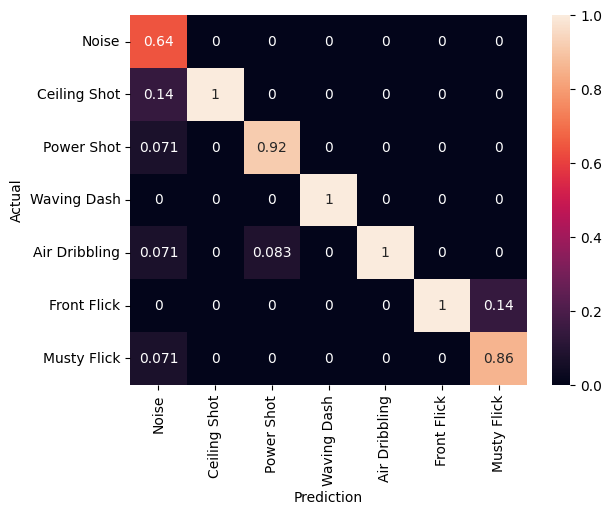

In [9]:
import time
t = time.time()
xgba= xgb_cross_val2.fit(train)
print(time.time()-t)
xgbd_predictions = xgba.transform(test)
print("Best parameters:")
print(max(xgba.avgMetrics))
print({k.name : v for (k,v) in xgba.getEstimatorParamMaps()[np.argmax(xgba.avgMetrics)].items()})
print_metrics(xgbd_predictions)

Best parameters:
0.8533618892253707
{'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.9, 'colsample_bytree': 0.9, 'n_estimators': 15, 'reg_lambda': 1, 'reg_alpha': 0.75, 'gamma': 0.1}


2023-10-01 16:28:46,043 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-01 16:28:46,140 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy: 
0.833
Weighted precision: 
0.863
Weighted recall: 
0.833


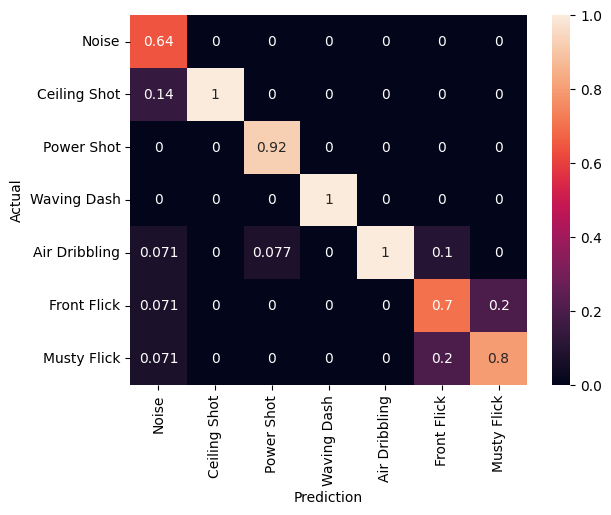

In [7]:
xgbd_predictions = xgba.transform(test)
print("Best parameters:")
print(max(xgba.avgMetrics))
print({k.name : v for (k,v) in xgba.getEstimatorParamMaps()[np.argmax(xgba.avgMetrics)].items()})
print_metrics(xgbd_predictions)

In [11]:
xgba.save("./models/xgb/hyperParameterTunedunder")

2023-10-01 17:58:56,494 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-01 17:58:56,599 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy: 
0.929
Weighted precision: 
0.930
Weighted recall: 
0.929


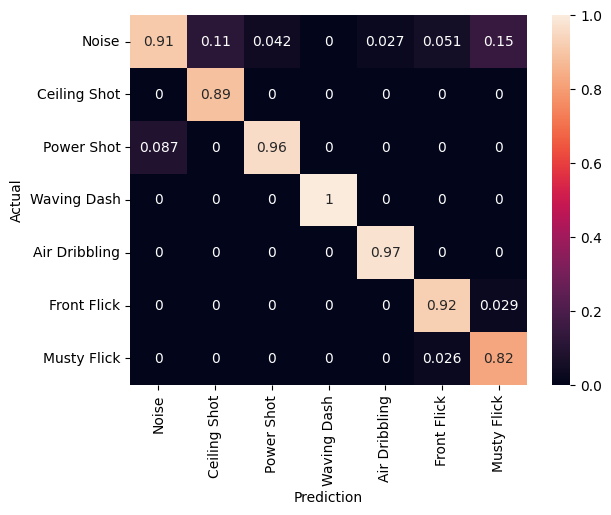

In [12]:
print_metrics(xgba.transform(train))

In [5]:
print(max(xgbfd.avgMetrics))

NameError: name 'xgbfd' is not defined

2023-09-30 21:12:20,300 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 8, 'random_state': 42, 'reg_lambda': 0.1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[21:12:22] task 0 got new rank 0                                    (0 + 1) / 1]
2023-09-30 21:12:24,031 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs


Accuracy: 
0.950
Weighted precision: 
0.955
Weighted recall: 
0.950


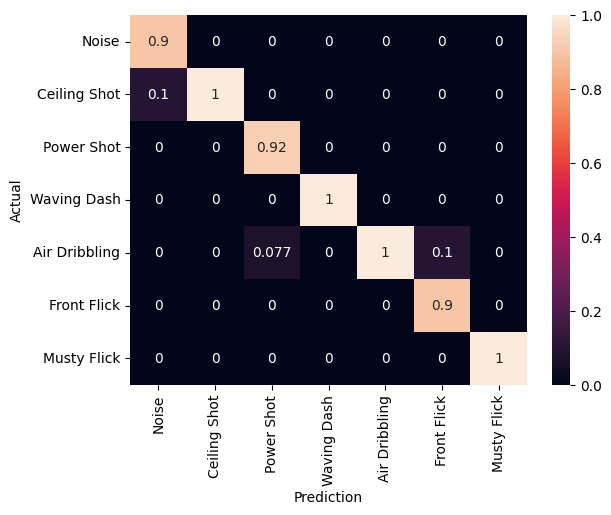

In [127]:
from pyspark.sql.types import DoubleType
d = {0: 0.1,1:1.0,2:0.5,3:0.8,4:0.66,5:0.65,6:0.83}
a = F.udf(lambda x: d[x], DoubleType())
#a = F.udf(lambda x: 0.1 if x==0 else 1., DoubleType())
train_w = train.withColumn("weights", a(F.col("class")))
xgb_cv3 = SparkXGBClassifier(features_col='features',
                         label_col='class',
                         weight_col='weights',
                         verbose=0,
                         random_state=seed, n_estimators=50, learning_rate=0.1, reg_lambda=0.1, max_depth=8, gamma=0.05, subsample=0.75)
xgbfd = xgb_cv3.fit(train_w)
xgbd_predictions = xgbfd.transform(test)
print_metrics(xgbd_predictions)

2023-09-30 21:14:22,553 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 8, 'random_state': 42, 'reg_lambda': 0.1, 'subsample': 0.75, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': 0, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[21:14:23] task 0 got new rank 0                                    (0 + 1) / 1]
2023-09-30 21:14:25,107 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs


Accuracy: 
1.000
Weighted precision: 
1.000
Weighted recall: 
1.000


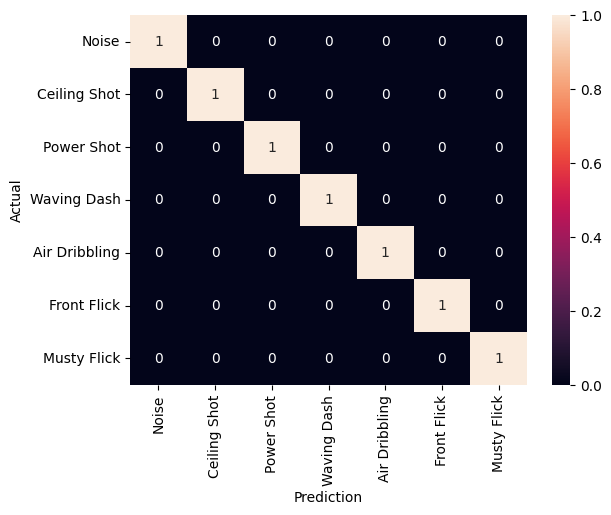

In [133]:
xgb_cv3 = SparkXGBClassifier(features_col='features',
                         label_col='class',
                         verbose=0,
                         random_state=seed, n_estimators=50, learning_rate=0.1, reg_lambda=0.1, max_depth=8, gamma=0.05, subsample=0.75)
xgbfd = xgb_cv3.fit(train)
xgbd_predictions = xgbfd.transform(test)
#print_metrics(xgbd_predictions)
tt = xgbfd.transform(train)
print_metrics(tt)

# COMMENTI RISULTATI

## SVM
SVM is the only model we apply the One-vs-Rest technique as PySpark offers only the LinearSVC as Support Vector Machine, which is a binary classifier.

In [21]:
svm = OneVsRest(classifier=LinearSVC(), featuresCol='features', labelCol='class', parallelism=2)
# fitting the model
svmf = svm.fit(train)
# saving
svmf.save(model_path+"svm/base")

+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       0.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       6.0|
|    5|       5.0|
|    5|       0.0|
|    6|       6.0|
|    6|       6.0|
|    1|       1.0|
|    1|       4.0|
|    1|       0.0|
+-----+----------+
only showing top 15 rows



Accuracy: 
0.767
Weighted precision: 
0.815
Weighted recall: 
0.767


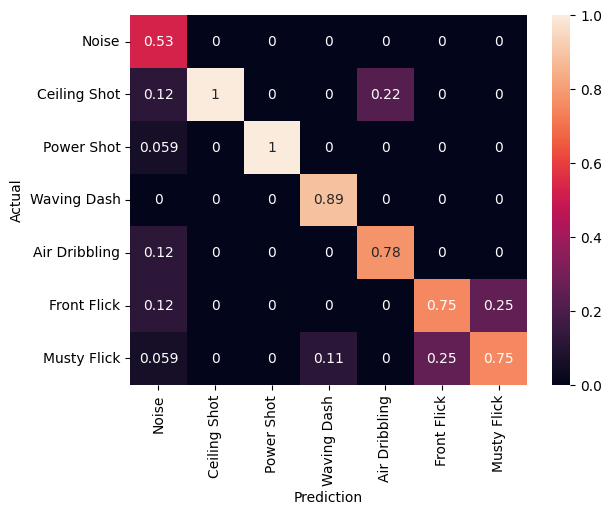

In [25]:
# getting the results
svm_predictions = svmf.transform(test)
svm_predictions.select('class', 'prediction').show(15)
print_metrics(svm_predictions)

In order to tune the LinearSVC, we choose the following hyperparameters:
- Maximum number of iterations: in {50, 100, 500};
- Regularization parameter: in {0.001, 0.01, 0.1, 1.0, 10, 100, 1000};
- Whether to fit an intercept term: True or False;
- Cpnvergence tolerance: in {1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6}.

In [7]:
# base model
svm_base = LinearSVC()
svm_cv = OneVsRest(classifier=svm_base,featuresCol='features', labelCol='class')

# building the grid
svm_param_grid = ParamGridBuilder()\
    .addGrid(svm_base.maxIter, [50,100,500 ])\
    .addGrid(svm_base.regParam, [0.001, 0.01, 0.1, 1.0, 10, 100, 1000])\
    .addGrid(svm_base.fitIntercept, [True, False])\
    .addGrid(svm_base.tol, [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')
svm_cross_val = CrossValidator(estimator=svm_cv,
                              estimatorParamMaps=svm_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [ ]:
svm_cv_model = svm_cross_val.fit(train)

Here we save the model and plot the best hyperparameters found...

In [59]:
print("Best parameters:")
print({k.name : v for (k,v) in svm_cv_model.getEstimatorParamMaps()[np.argmax(svm_cv_model.avgMetrics)].items()})
svm_cv_model.save(model_path+"svm/hyperParameterTuned")

Best parameters:
{'fitIntercept': True, 'regParam': 0.1, 'tol': 0.01, 'maxIter': 50}


...And the results.

+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    6|
|       6.0|    6|
|       0.0|    1|
|       1.0|    1|
|       0.0|    1|
+----------+-----+
only showing top 15 rows

Accuracy: 
0.817
Weighted precision: 
0.859
Weighted recall: 
0.817


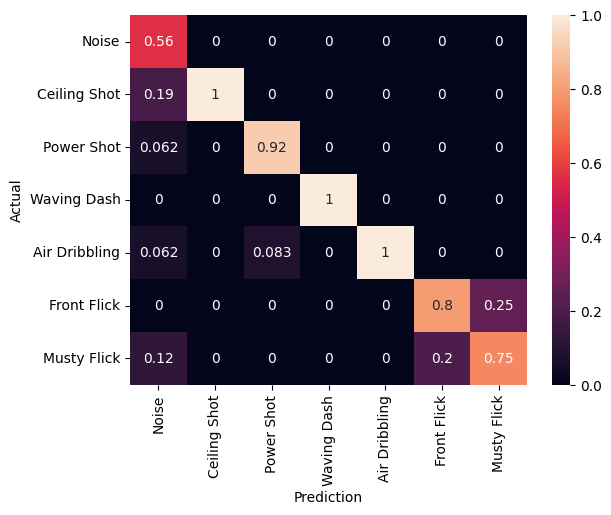

In [24]:
svm_best_pred = svm_cv_model.transform(test)
svm_best_pred.select("prediction", 'class').show(15)
print_metrics(svm_best_pred)

Also in the case of the SVM, the tuning procedure increased the overall performance of the model, improving by ~+0.5% accuracy and recall and + ~0.44% the precision.

Looking ad the confusion matrix, we see that:
- This model in its tuned form improves on the "Waving Dash", "Front Flick" and "Ceiling Shot" predictions;
- Both models still show some confusion on the "Front Flick" and "Musty Flick" classes due to their similarity;
- The tuned model tends to commit more errors in classfying the classes as noise rather than considering similar classes as done by the base model.

## Naive Bayes

In [12]:
nb = NaiveBayes(featuresCol='features', labelCol='class', smoothing=1e-9,
               modelType='gaussian')
# fitting the model
nbf = nb.fit(train)
# saving
nbf.save(model_path+"nb/base")


+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       2.0|
|    5|       6.0|
|    5|       5.0|
|    5|       5.0|
|    6|       6.0|
|    6|       0.0|
|    1|       1.0|
|    1|       0.0|
|    1|       0.0|
+-----+----------+
only showing top 15 rows

Accuracy: 
0.667
Weighted precision: 
0.742
Weighted recall: 
0.667


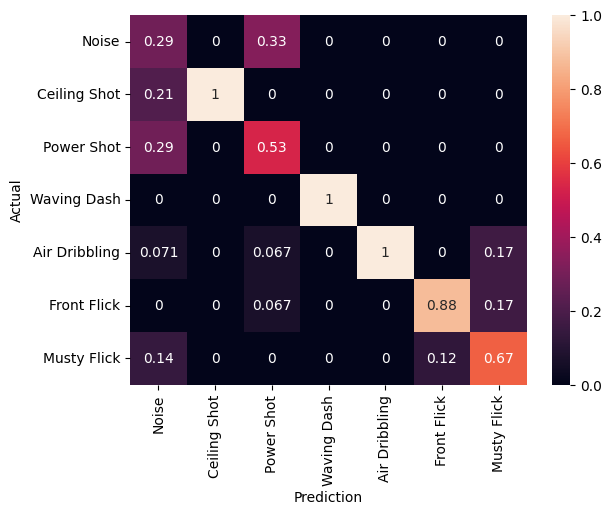

In [26]:
# getting the predictions
nb_predictions = nbf.transform(test)
nb_predictions.select('class', 'prediction').show(15)
print_metrics(nb_predictions)

The hyperparameter space of the Naive Bayes classifier is quite narrow, as it has only two parameters that can be reasonably tuned:
- Label smoothing: in {1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9};
- Type of the model: between multinomial, gaussian or bernoulli.

In [17]:
# base model
nb_cv = NaiveBayes(featuresCol='features', labelCol='class')

# building the grid
nb_param_grid = ParamGridBuilder()\
    .addGrid(nb_cv.smoothing, [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9])\
    .addGrid(nb_cv.modelType, ['multinomial','gaussian', 'bernoulli']).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

nb_cross_val = CrossValidator(estimator=nb_cv,
                              estimatorParamMaps=nb_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)

In [ ]:
nb_cv_model = nb_cross_val.fit(train)

Here we save the model and plot the best hyperparameters found...

In [63]:
print("Best parameters:")
print({k.name : v for (k,v) in nb_cv_model.getEstimatorParamMaps()[np.argmax(nb_cv_model.avgMetrics)].items()})
nb_cv_model.save(path+"models/nb/hyperParameterTuned")

Best parameters:
{'modelType': 'bernoulli', 'smoothing': 0.01}


...And the results.

+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    6|
|       0.0|    6|
|       1.0|    1|
|       0.0|    1|
|       0.0|    1|
+----------+-----+
only showing top 15 rows

Accuracy: 
0.783
Weighted precision: 
0.820
Weighted recall: 
0.783


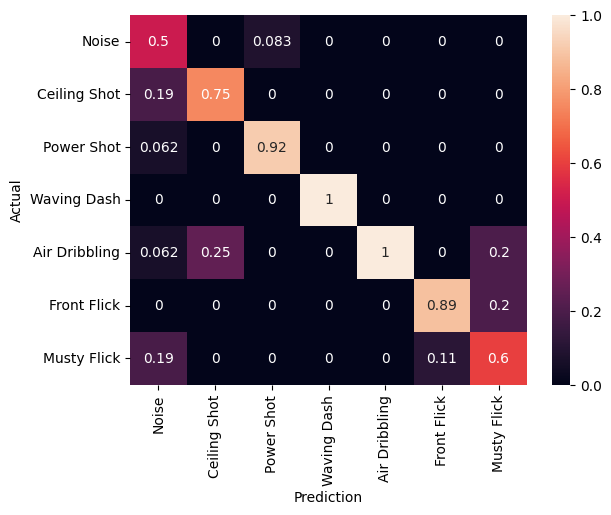

In [27]:
nb_best_pred = nb_cv_model.transform(test)
nb_best_pred.select("prediction", 'class').show(15)
print_metrics(nb_best_pred)

The Naive Bayes classifier is reconfirmed to be the less promising when compared to the others as it starts from a really low based performance. The Tuned version improves a lot on this, showing ~+1.5% on accuracy and recall and a +0.78% on precision.

We can see that:
- The base model commits most of the errors in classifying the "Noise" as "Power Shot".
- Both models tend to classify classes wrongly as noise (even if less in the tuned one) and to show some confusion on similar classes like "Front Flick" and "Musty Flick" and "Ceiling Shot" and "Air Dribbling".

## Summary of the results and final comments
Before presenting the summarization of the results, we add two cells: one to generate the predictions in case the models have been loaded and the other to generate the metrics to be displayed

In [10]:
# generate predictions if the models have been loaded
dtc_predictions = dtcf.transform(test)
rfc_predictions = rfcf.transform(test)
xgb_predictions = xgbf.transform(test)
svm_predictions = svmf.transform(test)
nb_predictions = nbf.transform(test)

dtc_best_pred = dtc_cv_model.transform(test)
rfc_best_pred = rfc_cv_model.transform(test)
xgb_best_pred = xgb_cv_model.transform(test)
svm_best_pred = svm_cv_model.transform(test)
nb_best_pred = nb_cv_model.transform(test)

In [ ]:
# generate metrics
dtc_metrics = compute_metrics(dtc_predictions)
rfc_metrics = compute_metrics(rfc_predictions)
xgb_metrics = compute_metrics(xgb_predictions)
svm_metrics = compute_metrics(svm_predictions)
nb_metrics = compute_metrics(nb_predictions)

dtc_best_metrics = compute_metrics(dtc_best_pred)
rfc_best_metrics = compute_metrics(rfc_best_pred)
xgb_best_metrics = compute_metrics(xgb_best_pred)
svm_best_metrics = compute_metrics(svm_best_pred)
nb_best_metrics = compute_metrics(nb_best_pred)

We then plot summarizing barplots showing side-to-side accuracy, weighted precision and weighted recall for each model, before and after tuning

In [29]:
model_names = ['DT', 'RF', 'XGB', 'SVM', 'NB']
final_metrics = [dtc_metrics, rfc_metrics, xgb_metrics, svm_metrics, nb_metrics]
improved_metrics = [dtc_best_metrics, rfc_best_metrics, xgb_best_metrics, svm_best_metrics, nb_best_metrics]
# width is used to control the width of the bars in the following plots
width=0.25

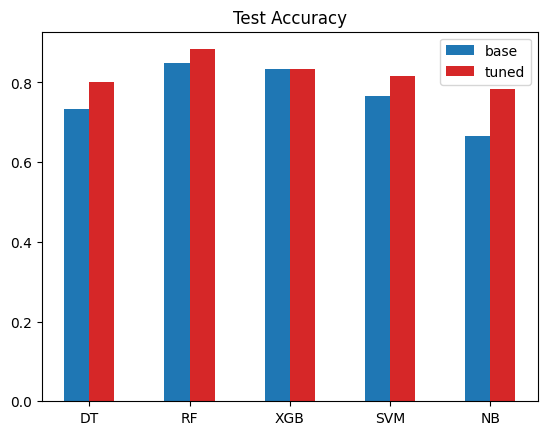

In [101]:
plt.title("Test Accuracy")
# plotting final accuracy in blue
plt.bar(np.arange(len(model_names)),
        [i.accuracy for i in final_metrics],
        color='tab:blue', label='base',
       width=width)
# plotting improved accuracy in red
plt.bar(np.arange(len(model_names))+width,
        [i.accuracy for i in improved_metrics],
        color='tab:red', label="tuned",
       width=width)
plt.xticks(np.arange(len(model_names))+width/2, model_names)
plt.legend()
plt.show()

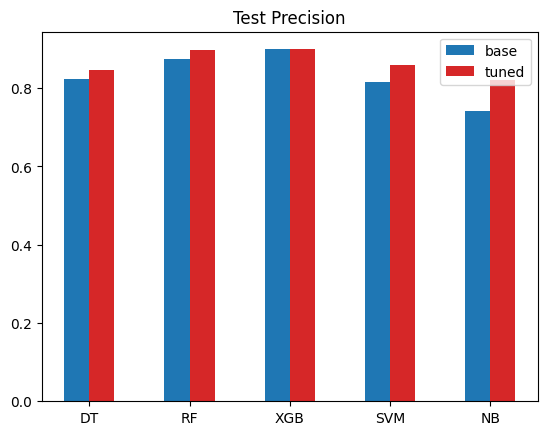

In [100]:
plt.title("Test Precision")
# plotting final precision in blue
plt.bar(np.arange(len(model_names)),
        [i.weightedPrecision for i in final_metrics],
        color='tab:blue', label='base',
       width=width)
# plotting improved precision in red
plt.bar(np.arange(len(model_names))+width,
        [i.weightedPrecision for i in improved_metrics],
        color='tab:red', label="tuned",
       width=width)
plt.xticks(np.arange(len(model_names))+width/2, model_names)
plt.legend()
plt.show()

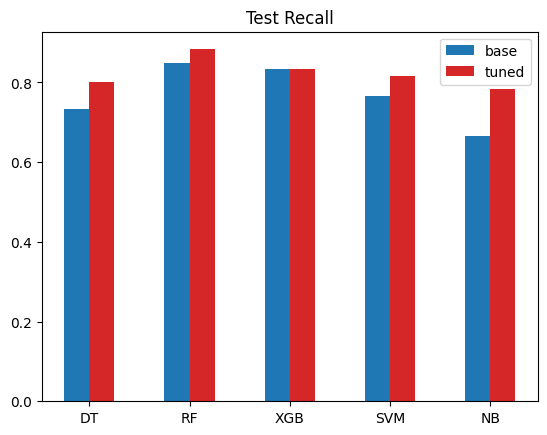

In [99]:
plt.title("Test Recall")
# plotting final recall in blue
plt.bar(np.arange(len(model_names)),
        [i.weightedRecall for i in final_metrics],
        color='tab:blue', label="base",
       width=width)
# plotting improved recall in red
plt.bar(np.arange(len(model_names))+width,
        [i.weightedRecall for i in improved_metrics],
        color='tab:red', label='tuned',
       width=width)
plt.xticks(np.arange(len(model_names))+width/2, model_names)
plt.legend()
plt.show()

# AGGIUNGERE CONCLUSIONI